# Image Generation Tasks

Created by Chenran Ning (cn257@cornell.edu)

Includings:
- Image Generation APIs from DALLE2
- Image UpSample : [link](https://colab.research.google.com/drive/1Sxp52p43Bx5yuF9rAoHg3N3K9ufvutuU?authuser=1#scrollTo=tuKu18UYptkx)

## Image Generation

In [ ]:
# Environment
!pip install openai
!pip install pillow

import openai
# Set your API key from openai
openai.api_key = "YOUR_KEY_HERE"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 KB 2.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Image Generate


import urllib.request
from PIL import Image
from matplotlib import pyplot as plt
import math
import os
import cv2
import numpy as np


class ImageGen():
    def __init__(self, n=2, size="1024x1024"):
        self.n = n
        self.size = size

    # generate from prompt
    def generate_images(self, prompt, n=2, ifshow=True):
        self.n = n
        response = openai.Image.create(
            prompt=prompt,
            n=self.n,
            size=self.size
        )
        image_paths = []
        for index, image in enumerate(response['data']):
            url = image['url']
            file_name = str(index) + ".png"
            urllib.request.urlretrieve(url, file_name)
            image_paths.append(file_name)
        if ifshow:
            self.show_images(image_paths)
        return image_paths

    # generate variations from image
    def generate_variations(self, variation_path, ifshow=True):
        # generate
        response = openai.Image.create_variation(
            image=open(variation_path, "r"),
            n=self.n,
            size=self.size
        )
        image_paths = []
        prompt = '_'.join(prompt.split(" "))
        # check if exists
        last_number = 0
        for f in os.listdir():
            if f.startswith(prompt):
                last_number = max(last_number, int(f.strip(".png").split('_')[-1]))

        for index, image in enumerate(response['data']):
            url = image['url']
            file_name = str(index + last_number) + ".png"
            urllib.request.urlretrieve(url, file_name)
            image_paths.append(file_name)
        if ifshow:
            self.show_images(image_paths)
        return image_paths

    # show images
    def show_images(self, image_paths, ncols=4):
        images = []
        for path in image_paths:
            img = Image.open(path)
            # img = cv2.imread(path)
            images.append(np.array(img))
        images = np.array(images)
        index, height, width, channels = images.shape
        nrows = math.ceil(index / ncols)
        fig = plt.figure(figsize=(4*ncols, 4*nrows))
        fig.suptitle(' '.join(image_paths[0].split('.')[0].split('_')[:-1]))
        for i in range(index):
            fig.add_subplot(nrows, ncols, i + 1)
            # showing image
            plt.title(image_paths[i].split('.')[0].split('_')[-1])
            plt.imshow(images[i])
            plt.axis('off')
        fig.show()

    # high resolution
    def high_resolution():
        pass


### Change Prompts

In [ ]:
n = 4
size = "512x512"

# variation path
variation_path = "/content/a_side_table_on_a_hoverboard._Product_design._1.png"

model = ImageGen(n, size)

### Generate from Prompts

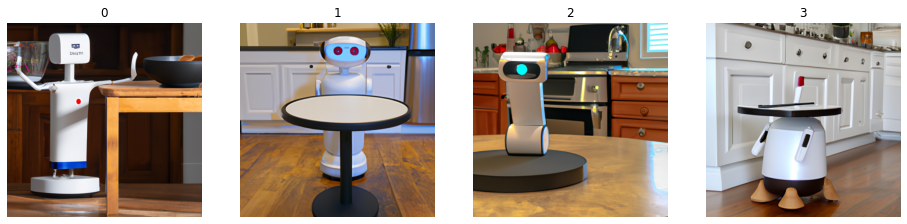

In [ ]:
model.n = 4
prompt = "a moveable side table robot that follows a person around while they cook in the kitchen, allowing them to remain on a facetime call with a friend and ensuring that the iPad camera is always pointed at them for a face-to-face communication experience."
image_paths = model.generate_images(prompt, n=4)
# image_paths = model.generate_variations(variation_path)
# print(image_paths)
# model.show_images(image_paths)

## Image Upsample

can use GPU

In [ ]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  print(image.shape)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [ ]:
def get_high_resolution(image_path):
    hr_image = preprocess_image(image_path)
    file_name = image_path.strip(".png") + "_high.png"
    # Plotting Original Resolution image
    # plot_image(tf.squeeze(hr_image), title="Original Image")
    # save_image(tf.squeeze(hr_image), filename="Original Image")
    model = hub.load(SAVED_MODEL_PATH)
    start = time.time()
    fake_image = model(hr_image)
    fake_image = tf.squeeze(fake_image)
    print("Time Taken: %f" % (time.time() - start))
    # Plotting Super Resolution Image
    # plot_image(tf.squeeze(fake_image), title="Super Resolution")
    save_image(tf.squeeze(fake_image), filename=file_name)

In [ ]:
# gpu
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3238866096588489008
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14401011712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6606949170942190130
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
1 Physical GPUs, 1 Logical GPU


In [ ]:
# Declaring Constants
IMAGE_PATH = "/content/DALL·E 2023-02-20 09.01.00 - blackhole stretched vertically, surrounding a massive swirling maelstrom, an extremely small spaceship in the front, sci-fi film by Christopher Nolan,.png"

get_high_resolution(IMAGE_PATH)

Downloaded https://tfhub.dev/captain-pool/esrgan-tf2/1, Total size: 20.60MB

Time Taken: 21.923933
Saved as /content/DALL·E 2023-02-20 09.01.00 - blackhole stretched vertically, surrounding a massive swirling maelstrom, an extremely small spaceship in the front, sci-fi film by Christopher Nolan,_high.png.jpg
